In [13]:
import pandas as pd
import requests
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

In [15]:
#Rutine to clean and format the MTA data
def clean_n_format(turns_df, upper_lim):
    turns_df.rename(columns={column:column.strip() for column in turns_df.columns}, inplace=True)
    turns_stations = turns_df 
    #Getting entries and exits per time interval
    turns_stations[["REAL_ENTRIES", "REAL_EXITS"]] = (turns_stations.groupby(["C/A", "UNIT", "SCP", "STATION","DATE"])
                                                  ["ENTRIES", "EXITS"]
                                                  .transform(lambda x: x - x.shift(1)))
    #Droping negative entries and exits
    turns_stations = (turns_stations.drop(turns_stations
                    [(turns_stations["REAL_EXITS"] < 0) | (turns_stations["REAL_ENTRIES"] < 0)].index))
    turns_stations["TOTAL_REAL"] = turns_stations["REAL_ENTRIES"] + turns_stations["REAL_EXITS"]
    turns_stations = (turns_stations.drop(turns_stations[turns_stations["TOTAL_REAL"] > upper_lim].index))
    #Adding up all entries+exits for each station at a given date and time interval 
    turns_stations_day_time = ((turns_stations.groupby(["STATION","DATE","TIME"])).sum().sort_values("TOTAL_REAL", ascending = False)
                           .reset_index())
    return(turns_stations_day_time)

In [16]:
#Break it up into morning + afternoon chunks
def get_time_chunk(date_time_object):
    dow = date_time_object.strftime('%A')
    noon = date_time_object.replace(hour=12, minute=0, second=0)
    if date_time_object.time() < noon.time() :
        dow += ' Morning'
    else :
        dow += ' Afternoon'
    return dow

In [17]:
#week_ids = [180616, 180609, 180602,180526, 170617, 170610, 170603,170527, 160618, 160611, 160604,160528]
week_ids = [180616]

In [18]:
turns_df = get_data(week_ids)

In [19]:
turns_df_2 = clean_n_format(turns_df, 100000)

In [20]:
#Adding DATE_TIME column
turns_df_2["DATE_TIME"] = pd.to_datetime(turns_df_2.DATE + " " + turns_df_2.TIME, format="%m/%d/%Y %H:%M:%S")

In [21]:
#Break it up into morning + afternoon chunks
turns_df_2['DOW'] = turns_df_2['DATE_TIME'].apply(get_time_chunk)
turns_df_2.head()

,STATION,DATE,TIME,ENTRIES,EXITS,REAL_ENTRIES,REAL_EXITS,TOTAL_REAL,DATE_TIME,DOW
0,34 ST-HERALD SQ,06/13/2018,20:00:00,1551289666,1352903004,51895.0,31802.0,83697.0,2018-06-13 20:00:00,Wednesday Afternoon
1,34 ST-HERALD SQ,06/14/2018,20:00:00,1551408597,1353014165,50291.0,32937.0,83228.0,2018-06-14 20:00:00,Thursday Afternoon
2,34 ST-HERALD SQ,06/12/2018,20:00:00,1551169419,1352792806,51797.0,31364.0,83161.0,2018-06-12 20:00:00,Tuesday Afternoon
3,34 ST-PENN STA,06/13/2018,20:00:00,1908770123,1709205488,35127.0,46377.0,81504.0,2018-06-13 20:00:00,Wednesday Afternoon
4,34 ST-PENN STA,06/14/2018,20:00:00,1908891139,1709315617,34866.0,45821.0,80687.0,2018-06-14 20:00:00,Thursday Afternoon


In [22]:
turns_stations_timechunks = ((turns_df_2.groupby(["STATION","DOW"])).sum().reset_index())
turns_stations_timechunks.sort_values("TOTAL_REAL", ascending = False).head()

,STATION,DOW,ENTRIES,EXITS,REAL_ENTRIES,REAL_EXITS,TOTAL_REAL
837,34 ST-PENN STA,Wednesday Afternoon,11941724506,8836266926,120289.0,122848.0,243137.0
3230,GRD CNTRL-42 ST,Wednesday Afternoon,3070848076,2873378212,132764.0,109086.0,241850.0
3226,GRD CNTRL-42 ST,Thursday Afternoon,3071337959,2873819465,131325.0,109521.0,240846.0
833,34 ST-PENN STA,Thursday Afternoon,11942253813,8836718258,119023.0,120751.0,239774.0
3228,GRD CNTRL-42 ST,Tuesday Afternoon,3070350031,2872932957,130597.0,106536.0,237133.0


In [23]:
turns_stations_timechunks.to_csv("MTA_Sample.csv")

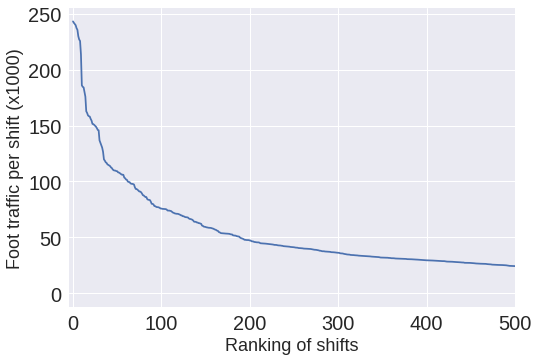

In [50]:
plt.style.use("seaborn")
figura = plt.figure()
Data_plot = (turns_stations_timechunks.sort_values("TOTAL_REAL", ascending = False).reset_index())["TOTAL_REAL"]/1000
Data_plot.plot(y="Total number")
plt.xlabel("Ranking of shifts",fontsize=18)
plt.ylabel("Foot traffic per shift (x1000)",fontsize=18)
plt.xlim([-5,500])
plt.tick_params(axis='both', labelsize=20)

In [51]:
figura.savefig('Max_num.jpg')

In [ ]:
(turns_stations_timechunks.sort_values("TOTAL_REAL", ascending = False).reset_index())["TOTAL_REAL"].head(20)